# Introduction
Ce projet est présenté par Samuel Bernier et Vincent Patry dans le cadre du projet synthèse du baccalauréat en informatique à l'Université du Québec en Outaouais (UQO). L'objectif de ce projet est d'implémenter l'algorithme BERT à des fins de détections de fausses nouvelles en rapport à la Covid-19. Ce présent document sert de démontrastion de notre implémentation et a pour but d'offrir suffisamment de détails afin que quiconque soit en mesure d'utiliser notre code. Les détails de notre rapport final, incluant toutes les sources utilisées, se trouve à l'adresse suivante: https://github.com/BernierS/Analyse_de_fausses_nouvelles

# Préparation des outils
La première étape est de confirmer que nous avons tous les outils nécessaires. Aux fins de se projet, nous recommandons d'utiliser python 3.9.7. Au moment de la rédaction de ce projet, certains outils utilisés n'étaient pas compatibles avec python 10. 

In [ ]:
!python --version

Python 3.9.7


Maintenant que nous avons vérifié la version de Python, nous devons installer plusieurs outils:

1. tensorflow_hub 
2. Keras
3. tf-models-official
4. pydot
5. graphviz

Afin d'obtenir plus de détails sur ces technologies, nous vous invitons à consulter le rapport: https://github.com/BernierS/Analyse_de_fausses_nouvelles



In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

!pip install -q -U tensorflow-text
!pip install -q tf-models-official==2.4.0

### Importation des librairies
Une fois que tous les paquets ont été installés, nous pouvons importer toutes les composantes dont nous avons besoin. Les librairies importées ici vont être utilisées tout au long du programme. 

In [ ]:
import os
import glob

import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt


### Vérification du matériel physique
Afin que notre programme s'exécute en un temps raisonnable, il est recommandé d'utiliser un GPU afin d'exécuter notre algorithme. La section de code suivante vérifie que le programme s'exécute bien sur au moins 1 GPU. Dans le cas échéant, il serait irréaliste d'exécuter ce programme sur un CPU, puisque la durée d'exécution sera excessivement longue. Si votre ordinateur ne possède pas de GPU, il est recommandé d'utiliser Google Colab. 

Le code est fourni directement par Tensorflow et peut se trouver ici: https://www.tensorflow.org/guide/gpu

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Transformation et vérification des Dataset
À la suite à nos recherches, nous avons décidé d'aller de l'avant avec cette source de donnée: https://ieee-dataport.org/open-access/covid-19-fake-news-infodemic-research-dataset-covid19-fnir-dataset

Il s'agit d'un ensemble de données incluant 3796 fausses nouvelles et 3794 vraies nouvelles en lien avec le Covid. Chaque nouvelle a été séparée dans deux fichiers Excel nommés "fakeNews.csv" et "trueNews.csv". Ceux-ci contiennent plusieurs informations tels que la région d'origine, le vérificateur de la nouvelle, etc. Afin d'utiliser ces fichiers, nous avons normalisé et combiné ceux-ci en un seul fichier à l'aide du code suivant.

REMARQUE: les "paths" (chemins) des fichiers sont directement sur mon ordinateur. Par conséquent, une personne désirant utiliser ce fichier devra télécharger les fichiers de la source et modifier le chemin menant à ces fichiers. 

Nous ne sommes pas les auteurs de cet ensemble de données, en voici la source:

Julio A. Saenz, Sindhu Reddy Kalathur Gopal, Diksha Shukla, June 12, 2021, "Covid-19 Fake News Infodemic Research Dataset (CoVID19-FNIR Dataset)", IEEE Dataport, doi: https://dx.doi.org/10.21227/b5bt-5244.

In [ ]:
# La ligne suivante doit être modifié selon l'emplacement de vos fichiers. 
all_filenames = ["Data\\fakeNews.csv", "Data\\trueNews.csv"]

df = pd.concat([pd.read_csv(f) for f in all_filenames ])
df = df.drop(['Date Posted', 'Link', 'Region', 'Country', 'Explanation', 'Origin', 'Origin_URL', 'Fact_checked_by', 'Poynter_Label', 'Username', 'Publisher'], axis=1)

# La méthode suivante sert à normaliser nos données d'entrée. Nous utilisons donc Regex afin de supprimer tous les liens, les "#", "@", etc.
# Le but est d'obtenir deux bases de données contenant des nouvelles vraie et fausse étant le plus uniformes possible. 
def rem(str):
    str = re.sub("(http).*?\s", "", str)
    str = re.sub("#", "", str)
    str = re.sub("@", "", str)
    str = re.sub("(pic.twitter.com).*?$", "", str)
    str = re.sub("\n", " ", str)
    str = re.sub("^\s", "", str)
    return str

# Cette ligne appelle la méthode plus haut et l'exécute sur chaque nouvelle de notre base de données. 
df['Text'] = df['Text'].map(rem)

# Cette ligne nous sert à exporter notre document une fois toutes les données normalisées. Ce document sert simplement à des fins de vérifier 
# le contenue une fois les étapes précédentes terminer. De cette façon, nous sommes en mesure de confirmer l'uniformité de nos données d'entrées.  
df.to_csv("combined.csv", index=False, encoding='utf-8-sig')

Nous avons maintenant terminé le téléchargement et la transformation de nos données, vérifions qu'elles sont conformes. Les deux sections suivantes servent à visualiser le résultat de nos opérations effectué à la section précédente. Une fois que nous avons confirmé que les données sont uniformes, nous sommes en mesure d'aller de l'avant.

In [ ]:
df.head()

,Text,Label
0,Tencent revealed the real number of deaths.\t\t,0
1,Taking chlorine dioxide helps fight coronaviru...,0
2,This video shows workmen uncovering a bat-infe...,0
3,The Asterix comic books and The Simpsons predi...,0
4,Chinese President Xi Jinping visited a mosque ...,0


In [ ]:
df.tail()

,Text,Label
3788,Global COVID-19 prevention trial of hydroxychl...,1
3789,Bavaria's free COVID-19 test for all splits Ge...,1
3790,Britain locks down city of Leicester after COV...,1
3791,UK imposes lockdown on city of Leicester to cu...,1
3792,"Grace Fusco, the matriarch of a large New Jers...",1


Afin de s'assurer que nos données sont conformes, vérifions que nous avons seulement 2 types d'arguments dans la catégorie "label". En temps normal, nous devons voir "0" et "1" en résultat ("0" est associé aux fausses nouvelles et "1" est associé aux vraies nouvelles).

In [ ]:
df.Label.unique()

array([0, 1], dtype=int64)

Maintenant, nous sommes en mesure de vérifier la répartition de nos données entre les nouvelles vraie et fausse. Il est important que la quantité de vraie et fausse nouvelles soit le plus près possible. Voici une représentation visuelle de notre répartition de donnée. 

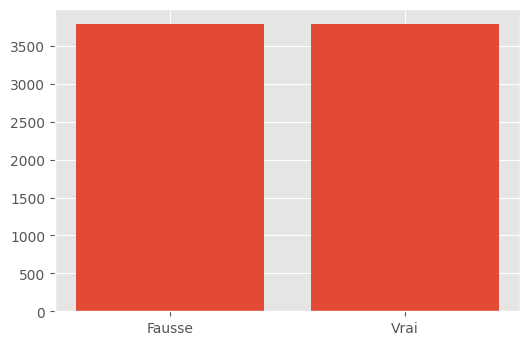

In [ ]:
classes = df.Label.unique()
counts = []

for i in classes:
  count = len(df[df.Label==i])
  counts.append(count)

plt.bar(['Fausse', 'Vrai'], counts)
plt.show()

# Codage des étiquettes
Maintenant que nos données ont été créés et vérifiées, nous sommes en mesure de les séparer.
La fonction "train_test_split()" sert à séparer efficacement nos données en quatre catégories:
1. x_train -> variable contenant 80% des textes d'entrée servant à entraîner l'algorithme BERT.
2. x_test -> variable contenant 20% des textes d'entrée servant à tester notre algorithme une fois qu'il a été entraîné. 
3. y_train -> variable contenant les "labels" (0 ou 1) associer aux textes de "x_train". 
4. y_test -> variable contenant les "labels" (0 ou 1) associer aux textes de "x_test". 

Les détails du fonctionnement de la méthode se trouvent à cette source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
# To remove?
sample_size = int(len(df))
sampleDf = df.sample(sample_size, random_state=23)

x = sampleDf.Text.values
y = sampleDf.Label.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

### LabelEncoder()
Cette section sert à normaliser les données d'entrée afin d'être utilisables par BERT. La documentation des méthodes utilisée peut être retrouvée ici: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# Convertis un vecteur en matrice
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

Une fois nos étiquettes créées, nous pouvons sauvegarder ce modèle afin de l'utiliser plus tard. 

In [ ]:
encoder_fname = 'FakeNews_classes.npy'

# La ligne suivante sert à préciser l'endroit ou sauvegarder le modèle. Si une personne utilisant ce programme désire sauvegarder le modèle à un endroit différent, 
# la ligne suivante doit être modifiée.
my_wd = ''
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

# Création des jetons (Tokenization)
Continuons maintenant avec le modèle BERT. L'algorithme BERT peut être entraîné sur plusieurs types de données différents selon le besoin. Dans notre situation, nous avons décidé d'opter pour un modèle multilinguiste, au cas où nous décidons d'analyser des nouvelles de diverses langues. Ce modèle fut entraîné sur Wikipédia, les détails se trouvent ci-dessous. 
Tensorflow offre plusieurs modèles open source que vous êtes en mesure de retrouver ici: https://tfhub.dev/s?module-type=text-embedding,text-classification,text-generation,text-language-model,text-question-answering,text-retrieval-question-answering.

Le modèle choisi a été entraîner par: Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova: "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding,” 2018. Ce dernier a été entrainé sur plusieurs pages de Wikipédia contenant plusieurs langues. Plus de détails ici: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2.

REMARQUE: Nous avons utilisé la deuxième version du modèle, cependant la quatrième version est disponible. L'implémentation de celle-ci sera différente, nous avons donc décidé de continuer notre implémentation avec la version 2. 

In [ ]:
# Importation du modèle choisi.
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2", trainable=True)

# Déclaration des variables nécessaires selon la documentation de ce modèle. Détails ci-dessous.
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Nous avons initié certaines valeurs de notre modèle, voici leurs fonctionnalités:

1.   "vocab_file" permet de lire le fichier "vocab", contenant le vocabulaire du modèle
2.   "do_lower_case" détermine si l'on doit transformer tous les textes en minuscule. Par défaut, ce paramètre devrait être "False".
3.   "tokenizer" crée le jeton selon les deux paramètres créer précédemment. 

Notre jeton a ensuite besoin de deux variable, classificateur et séparateur. Nous devons donc les ajouter de cette façon:

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Nous avons tous ce qu’il nous faut afin de procéder à la "tokenization". Nous ajoutons un [SEP] entre chaque jeton afin de séparer les données. Chaque mot va ensuite être remplacé par son chiffre équivalent selon le modèle de BERT choisi. Le but est de créer une matrice avec nos données d'entrée et d'analyser celles-ci. 

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

text_data = tf.ragged.constant([
    encode_names(n) for n in x_train])

Voici donc à quoi ressemblent nos textes suite à la tokenization. 

In [ ]:
text_data[0]

<tf.Tensor: shape=(23,), dtype=int32, numpy=
array([10117, 13299, 14424, 13575, 16411, 25907, 80352, 10107, 10189,
       11155, 10301, 10798, 11084, 10233,   117, 10259, 50438, 10188,
       31206, 37715, 10251,   119,   102])>

Afin de mieux comprendre comment notre texte s'est transformé en matrice de nombres, voici à quoi ressemble le texte original:

In [ ]:
x_train[0]

'The Chinese news website Tencent filters that there are more than 24,000 deaths from coronavirus.\t\t'

Voici ensuite la valeur de chaque mot selon la matrice créée:

In [ ]:
tokenizedText = tokenizer.tokenize(x_train[0])
for i in tokenizedText:
  print(i, tokenizer.convert_tokens_to_ids([i]))

The [10117]
Chinese [13299]
news [14424]
website [13575]
Ten [16411]
##cent [25907]
filter [80352]
##s [10107]
that [10189]
there [11155]
are [10301]
more [10798]
than [11084]
24 [10233]
, [117]
000 [10259]
deaths [50438]
from [10188]
corona [31206]
##vir [37715]
##us [10251]
. [119]


Voici une représentation visuelle de nos jetons créés à l'étape précédente.

C:\Users\samue\AppData\Local\Temp\ipykernel_3788\2371236668.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = plt.pcolormesh(input_word_ids[0:10].to_tensor())


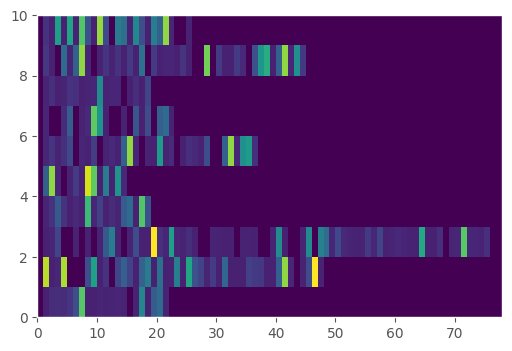

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*text_data.shape[0]
input_word_ids = tf.concat([cls, text_data], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

## Masque & type
Le modèle que nous utilisons a besoin de deux données supplémentaires. Le masque et le type. Le masque sert à différencier le contenu d'entrée (les textes) et le rembourrage que nous avons créé. Voir le graphe suivant pour une représentation visuelle. Les lignes jaunes sont les données d'entrée, et le mauve est le rembourrage. 

C:\Users\samue\AppData\Local\Temp\ipykernel_3788\2782785498.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(input_mask)


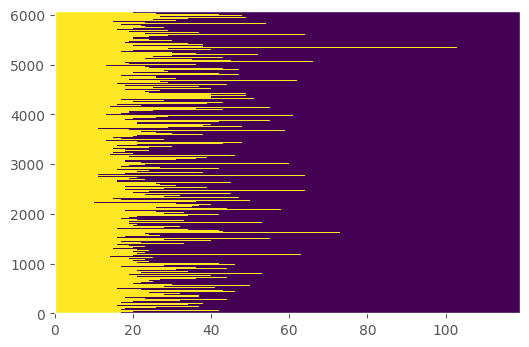

In [ ]:
input_word_ids
input_mask = tf.ones_like(input_word_ids).to_tensor()
plt.pcolormesh(input_mask)

Bien que le graphe ci-dessous est très similaire, nous avons ajouté un bloc vide [CLS] au début de chaque texte (en mauve), afin d'insérer le jeton CLS (classification). 

C:\Users\samue\AppData\Local\Temp\ipykernel_3788\432401105.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(input_type_ids)


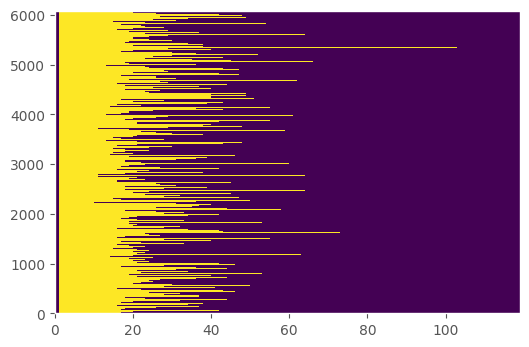

In [ ]:
type_cls = tf.zeros_like(cls)
type_text = tf.ones_like(text_data)
input_type_ids = tf.concat([type_cls, type_text], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

La variable "input_type_ids" représente à quoi va ressembler nos matrices d'entrer. Plus de détails ici: https://www.tensorflow.org/hub/common_saved_model_apis/text#transformer-encoders

In [ ]:
input_type_ids

<tf.Tensor: shape=(6070, 119), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])>

# Création d'une fonction afin de simplifier les étapes
Afin de simplifier les étapes suivantes, nous allons créer une fonction permettant d'utiliser notre modèle. Cette fonction reprend certains éléments définis plus haut à des fins de clarté. 

Commençons tout d'abord à créer une longueur maximum de nos données d'entrées. Nous allons prendre le texte d'entré le plus long, puis le multiplier par 1.5, au cas ou un de nos textes d'entrer s'avère plus long que nos données d'entrées initiales. 

In [ ]:
lens = [len(i) for i in input_word_ids]
max_seq_length = max(lens)
print('Longueure maximum initiale: ', max_seq_length)

max_seq_length = int(1.5*max_seq_length)
print('Longueure maximum utilisé: ', max_seq_length)

Longueure maximum initiale:  119
Longueure maximum utilisé:  178


Nous sommes ensuite en mesure de créer les fonctions réutilisables afin de rendre le prétraitement plus facile. Ceux-ci ont été décrits plus haut.

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

Nous sommes maintenant prêts à faire le prétraitement de nos données

In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

# Modélisation 
## Traitement initiale
Nous sommes maintenant prêts à la modélisation. Nous créons notre modèle à l'aide de nos données d'entrées, du modèle BERT que nous avons choisi, ainsi qu'une couche de sortie selon le notre nombre de classes. Le code suivant provient de notre modèle source, les détails de l'utilisation se trouvent ici: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2

In [ ]:
num_class = len(encoder.classes_)  # Basée sur le nombre de classes utilisé (0-1)
max_seq_length = max_seq_length  # Longueur de texte calculé plus haut

# Créer selon le modèle multilingual choisi
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

# Créer selon le modèle multilingual choisi
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  
output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)
output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

Voici à quoi ressemble notre modèle. Nous avons le input_word_ids (les données d'entrée), le input_mask (le masque), et le segment_ids (afin de segmenter nos données). Le tout est exécuté dans la couche de Keras, pour ensuite nous donner le résultat final (output). 

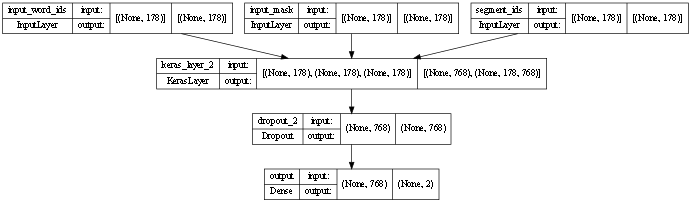

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

## Entrainement de BERT
Nous pouvons maintenant initier les paramètres de notre entrainement. Epochs est le nombre d'itérations de notre algorithme. Dans notre situation, nous avons décidé de procéder seulement à trois itérations. Le batch_size devrait être augmenté selon le VRAM de votre GPU. Puisque ce notebook a pour but d'être utilisé par plusieurs personnes avec divers GPU, nous avons décidé de le laisser à 16. Cependant, une personne ayant un bon GPU pourrait l'augmenter afin d'augmenter la rapidité de l'algorithme. 

In [ ]:
epochs = 3  # Nombre d'itération à faire. Par conséquent, nous allons entrainer notre algorithme 3 fois.
batch_size = 16 # Peut-être ajusté selon le VRAM de notre GPU. Plus le nombre est grand, plus notre GPU a besoin de VRAM. 16 est un bon chiffre pour Google Colab.
eval_batch_size = batch_size  # Utile?

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)


Une fois tous les paramètres déterminés, nous sommes en mesure de compiler le modèle. Voici à quoi ressemble la compilation du modèle.

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 178)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 178)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 178)]        0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 178, 768)]                'input_mask[0][0]',       

Tel que nous pouvons le constater, le modèle choisi utilise un total de 177M de paramètre. Voilà la raison d'où BERT est plus performant qu'un réseau de neurones traditionnel, un réseau traditionnel aurait environ 10M de paramètre. Par conséquent, notre modèle devrait être plus précis. 

## Exécution de l'algorithme
Voici maintenant l'exécution de notre algorithme. Si vous utilisez les machines virtuelles de Google Colab, l'algorithme prendra de 30 à 45 minutes à compiler. Évidemment, le temps va grandement varier selon le nombre de données d'entrées. De plus, si l'exécution se fait sur un meilleur système, il sera beaucoup plus rapide. Sur notre ordinateur personnel, cette étape prend seulement 3 à 4 minutes. Voici les spécifications de notre ordinateur utilisé pour comparaison:
CPU: AMD Ryzen 9 3900X 12 Cores 24 Threads @ 4.00 GHz
RAM: 32Gb DDR4 3200MHz
GPU: Nvidia GeForce RTX 3090 - 10,496 CUDA Cores

***REMARQUE***: La pièce la plus importante ici est le GPU. Puisque nous utilisons la parallélisation, le nombre de CUDA Cores du GPU est très important. La version gratuite de Google Colab utilise des GPU NVIDIA® Tesla® K80, possédant 4,991 CUDA Cores. Notre exécution de code est donc beaucoup plus rapide, puisque nous avons un peu plus que le double de CUDA Cores. 

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
380/380 [==============================] - 77s 174ms/step - loss: 0.1868 - accuracy: 0.9257 - val_loss: 0.1074 - val_accuracy: 0.9704
Epoch 2/3
380/380 [==============================] - 66s 173ms/step - loss: 0.0538 - accuracy: 0.9863 - val_loss: 0.0517 - val_accuracy: 0.9855
Epoch 3/3
380/380 [==============================] - 66s 173ms/step - loss: 0.0153 - accuracy: 0.9951 - val_loss: 0.0692 - val_accuracy: 0.9875


Les résultats sont très prometteurs: 

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Précision de l'entrainement: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Précision des tests:  {:.4f}".format(accuracy))

Précision de l'entrainement: 0.9987
Précision des tests:  0.9875


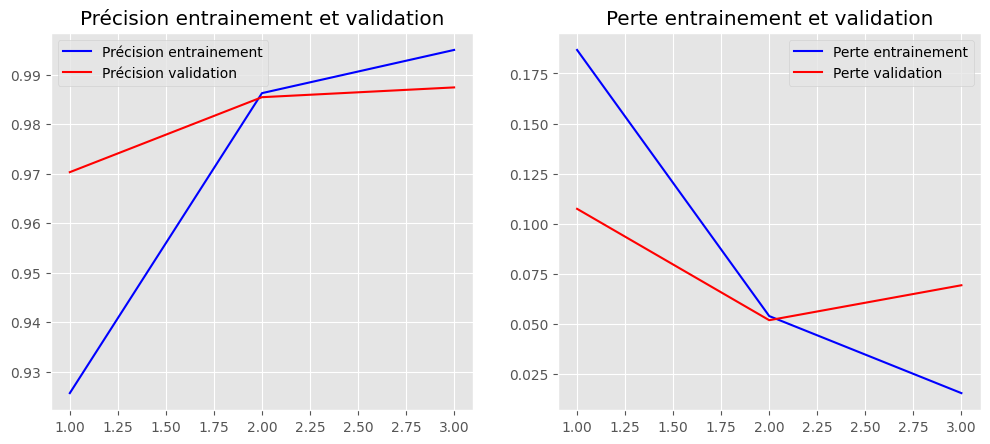

In [ ]:
# Utilisation de la librairie matplotlib afin d'afficher les résultats
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Précision entrainement')
    plt.plot(x, val_acc, 'r', label='Précision validation')
    plt.title('Précision entrainement et validation')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Perte entrainement')
    plt.plot(x, val_loss, 'r', label='Perte validation')
    plt.title('Perte entrainement et validation')
    plt.legend()

plot_history(history)

Les sections suivantes servent simplement à sauvegarder notre modèle

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Le chemin "my_wd" devra être modifié selon l'utilisateur

model_fname = 'fakenews_BERT'
my_wd = ''

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: fakenews_BERT\assets


INFO:tensorflow:Assets written to: fakenews_BERT\assets


In [ ]:
model_fname = 'fakenews_BERT'
new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Précision des tests::  {:.4f}".format(accuracy))

Précision des tests::  0.9875


In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

# Application de l'algorithme

In [ ]:
encoder_fname = 'FakeNews_classes.npy'
my_wd = ""

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

### Création des statistiques
La section suivante démontre les résultats de notre projet. Nous avons décidé de prendre une base de données d'environ 5.2 millions d'articles et nouvelles en lien avec le Covid-19 sur une période de 4 mois (décembre 2019 à Mars 2020). Puisque notre algorithme à été conçu à l'aide de tweets et titre de nouvelle, nous avons décidé d'appliquer notre algorithme à tous les titres de cette base de données. Il est important de noter que chaque titre contenant moins de 30 caractères a été retiré de la liste, puisqu'il est difficile d'analyser un texte si court. Au final, nous avons compilé nos résultats en divers graphique selon ce que nous avons trouvé d'intéressant, à l'aide de la librairie Matplotlib: https://matplotlib.org/

Il est important de noter que l'analyse de cette massive quantité de données à duré prêt de 48h. Par conséquent, si vous désirer procéder à votre propre analyse, il sera impossible de le faire à l'aide de Google Colab gratuit. L'analyse a été effectuée sur l'ordinateur mentionné plus haut. 

Source de la base de données:
Ran Geva, March 31, 2020, "free dataset from news/message boards/blogs about CoronaVirus (4 month of data - 5.2M posts)", IEEE Dataport, doi: https://dx.doi.org/10.21227/kc4v-q323.

In [ ]:
import json
import glob
import re
import time
from tqdm import tqdm

# Liste des variables global
# Variable servant à trouver le total des sources vrai et fausse
total_true = 0
total_false = 0

# Dict des régions
region_dict_true = {}
region_dict_false = {}

# Dict des dates
date_dict_true = {}
date_dict_false = {}

# Variable servant à trouver quantité de likes qui viennent de sources vraie et fausse
total_like_fake_source = 0
total_like_true_source = 0

# Variable servant à trouver le nombre de partages sur Facebook par sources vraie et fausse
total_share_fake_source = 0
total_share_true_source = 0

#Variable servant à trouver la quantité de sources crédibles et non crédibles qui ont des risques bas, moyens, ou élevés de spams
#Voir https://www.reputio.com/what-is-spam-score/ en référence
total_vrai_bas_risque = 0
total_vrai_medium_risque = 0
total_vrai_haut_risque = 0
total_faux_bas_risque = 0
total_faux_medium_risque = 0
total_faux_haut_risque = 0

# Puisque la base de données utilise est de 13gb, il est impossible de la charger au complet en mémoire afin de faire l'analyse.
# Par conséquent, nous avons appelons cette méthode individuellement à chaque fichier JSON fournit par la base de données (chaque fichier est environ 0.5gb.)
def imp(single_file):
    dataList = []
    with open(single_file, encoding='utf-8') as f:
        for jsonObj in f:
            data = json.loads(jsonObj)
            dataList.append(data)
    tqdm.write('\n')


    #Initialisation des variables globales
    #En python, une variable globale "int" doit être réinitialisée à l'intérieur de la fonction afin de l'utiliser, contrairement à une liste.
    global total_true
    global total_false
    global total_like_true_source
    global total_like_fake_source
    global total_share_fake_source
    global total_share_true_source
    global total_vrai_bas_risque
    global total_vrai_medium_risque
    global total_vrai_haut_risque
    global total_faux_bas_risque
    global total_faux_medium_risque
    global total_faux_haut_risque

    # Boucle comprenant chaque calcul désiré
    # La librairie TQDM permet de visualiser la durée de l'algorithme et de donner une approximative quant à la fin de l'algorithme. 
    for data in tqdm(dataList, desc='Progrès', unit=' articles', position=0, mininterval=10):
        # Évaluation de la nouvelle
        txt = [data['title']]
        # Condition permettant de passer à la prochaine nouvelle si elle est trop courte (< 30 caractères)
        if len(str(txt))<30:
            continue

        # Partie la plus importante du code, cette section évalue si la nouvelle est vraie ou fausse. Le reste du code dépend de cette section.
        inputs = bert_encode(string_list=list(txt),
                         tokenizer=tokenizerSaved,
                         max_seq_length=178)
        prediction = new_model.predict(inputs)
        prediction_bool = encoder.classes_[np.argmax(prediction)]


        # Conditions permettant d'obtenir les régions par type de nouvelles
        if prediction_bool:
            # Permets d'obtenir la quantité de likes et partage qui viennent de sources vraie et fausse
            nb_like_fake_position_x = data['thread']['social']['facebook']['likes']
            total_like_fake_source = total_like_fake_source + nb_like_fake_position_x
            nb_share_fake_position_x = data['thread']['social']['facebook']['shares']
            total_share_fake_source = total_share_fake_source + nb_share_fake_position_x

            # Conditions permettant d'obtenir les régions par type de nouvelles
            total_true += 1
            region = data['thread']['country']
            if region in region_dict_true:
                region_dict_true[region] +=1
            elif region== '':
                pass
            else:
                region_dict_true.update({region: 1})

            # Conditions permettant d'obtenir les dates par type de nouvelles
            date = data['published']
            date = re.sub("(T).*", "", date)
            if date in date_dict_true:
                date_dict_true[date] += 1
            else:
                date_dict_true.update({date: 1})


        else:
            # Permets d'obtenir la quantité de likes et partage qui viennent de sources vraie et fausse
            nb_like_true_position_x = data['thread']['social']['facebook']['likes']
            total_like_true_source = total_like_true_source + nb_like_true_position_x
            nb_share_true_position_x = data['thread']['social']['facebook']['shares']
            total_share_true_source = total_share_true_source + nb_share_true_position_x

            # Conditions permettant d'obtenir les régions par type de nouvelles
            total_false += 1
            region = data['thread']['country']
            if region in region_dict_false:
                region_dict_false[region] +=1
            elif region== '':
                pass
            else:
                region_dict_false.update({region: 1})

            # Conditions permettant d'obtenir les dates par type de nouvelles
            date = data['published']
            date = re.sub("(T).*", "", date)
            if date in date_dict_false:
                date_dict_false[date] += 1
            else:
                date_dict_false.update({date: 1})


        # Conditions permettant d'obtenir la quantité de sources crédibles et non crédibles qui ont des risques bas, moyens, ou élevés de spams
        if data['thread']['spam_score'] < 0.114 and prediction_bool==True:
            total_vrai_bas_risque += 1
        elif data['thread']['spam_score'] <= 0.56 and prediction_bool==True:
            total_vrai_medium_risque += 1
        elif data['thread']['spam_score'] > 0.56 and prediction_bool==True:
            total_vrai_haut_risque += 1
        elif data['thread']['spam_score'] < 0.114 and prediction_bool==False:
            total_faux_bas_risque += 1
        elif data['thread']['spam_score'] <= 0.56 and prediction_bool==False:
            total_faux_medium_risque += 1
        elif data['thread']['spam_score'] > 0.56 and prediction_bool==False:
            total_faux_haut_risque += 1

# Variable identifiant si l'on veut exécuter l'algorithme sur la totalité des données (files) ou tester l'algorithme sur un nombre réduit de données (filesTest). 
# Tel que mentionné plus haut, il faudra possiblement ajuster le chemin menant à ces fichiers selon l'organisation des fichiers. 
# Nous recommandons de tester l'algorithme sur une quantité réduite de données afin de s'amurer que le tout fonctionnel. 
files = glob.glob('JsonFiles/*.json', recursive=True)
filesTest = glob.glob('JsonTest/*.json', recursive=True)

C:\Users\samue\anaconda3\envs\gpu7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
start = time.time()

# La variable "files" doit être modifiée si l'on désire exécute l'analyse sur la base de données complète, ou sur la base de données tests.  
# Modifier TQDM
for single_file in tqdm(files, desc='Progrès total', unit=' Articles', position=0, leave=False):
    imp(single_file)


time.sleep(10)
done = True

end = time.time()
print("")
print("Temps d'exécution en secondes: ", end - start)
print("Temps d'exécution en minutes: ", (end - start)/60)
print("Temps d'exécution en heures: ", ((end - start)/60)/60)
print("Temps d'exécution en jours: ", (((end - start)/60)/60)/24)

Progrès total:   0%|          | 0/31 [00:00<?, ? Articles/s]

Progrès total:   3%|▎         | 1/31 [00:13<04:08,  8.27s/ Articles]

Progrès total:   6%|▋         | 2/31 [2:00:59<34:23:14, 4268.77s/ Articles]

Progrès total:  10%|▉         | 3/31 [2:15:52<21:11:31, 2724.68s/ Articles]

Progrès total:  13%|█▎        | 4/31 [4:18:49<34:12:36, 4561.37s/ Articles]

Progrès total:  16%|█▌        | 5/31 [6:21:40<40:15:38, 5574.56s/ Articles]

Progrès total:  19%|█▉        | 6/31 [8:25:39<43:06:58, 6208.75s/ Articles]

Progrès total:  23%|██▎       | 7/31 [10:25:57<43:35:57, 6539.88s/ Articles]

Progrès total:  26%|██▌       | 8/31 [11:01:57<32:52:00, 5144.39s/ Articles]

Progrès total:  29%|██▉       | 9/31 [13:05:30<35:46:12, 5853.30s/ Articles]

Progrès total:  32%|███▏      | 10/31 [15:10:35<37:07:02, 6362.98s/ Articles]

Progrès total:  35%|███▌      | 11/31 [17:13:42<37:05:36, 6676.83s/ Articles]

Progrès total:  39%|███▊      | 12/31 [19:17:05<36:24:12, 6897.52s/ Articles]

Progrès total:  42%|████▏     | 13/31 [21:19:18<35:08:49, 7029.42s/ Articles]

Progrès total:  45%|████▌     | 14/31 [22:56:02<31:26:44, 6659.11s/ Articles]

Progrès total:  48%|████▊     | 15/31 [24:32:55<28:27:49, 6404.33s/ Articles]

Progrès total:  52%|█████▏    | 16/31 [26:11:28<26:04:03, 6256.20s/ Articles]

Progrès total:  55%|█████▍    | 17/31 [27:51:04<24:00:09, 6172.12s/ Articles]

Progrès total:  58%|█████▊    | 18/31 [29:29:55<22:01:33, 6099.48s/ Articles]

Progrès total:  61%|██████▏   | 19/31 [31:08:13<20:07:51, 6039.32s/ Articles]

Progrès total:  65%|██████▍   | 20/31 [32:46:33<18:19:28, 5997.18s/ Articles]

Progrès total:  68%|██████▊   | 21/31 [34:24:12<16:32:40, 5956.02s/ Articles]

Progrès total:  71%|███████   | 22/31 [36:01:32<14:48:07, 5920.86s/ Articles]

Progrès total:  74%|███████▍  | 23/31 [37:41:01<13:11:24, 5935.51s/ Articles]

Progrès total:  77%|███████▋  | 24/31 [39:18:49<11:30:05, 5915.06s/ Articles]

Progrès total:  81%|████████  | 25/31 [40:57:08<9:51:00, 5910.14s/ Articles] 

Progrès total:  84%|████████▍ | 26/31 [42:35:35<8:12:27, 5909.41s/ Articles]

Progrès total:  87%|████████▋ | 27/31 [44:13:56<6:33:47, 5906.88s/ Articles]

Progrès total:  90%|█████████ | 28/31 [45:52:03<4:55:02, 5900.81s/ Articles]

Progrès total:  94%|█████████▎| 29/31 [47:57:34<3:33:00, 6390.06s/ Articles]

Progrès total:  97%|█████████▋| 30/31 [50:03:31<1:52:20, 6740.55s/ Articles]

Progrès: 100%|██████████| 62420/62420 [1:18:38<00:00, 13.23 articles/s]
                                                                            


Temps d'exécution en secondes:  184941.81312155724
Temps d'exécution en minutes:  3082.363552025954
Temps d'exécution en heures:  51.372725867099234
Temps d'exécution en jours:  2.140530244462468


## Résultat

### Code affichant le nombre de vrai nouvelles détecter comparé au nombre de fausse nouvelles détecter. 
Tout les graphes suivants ont été créés à l'aide de la librairie Matplotlib: https://matplotlib.org/

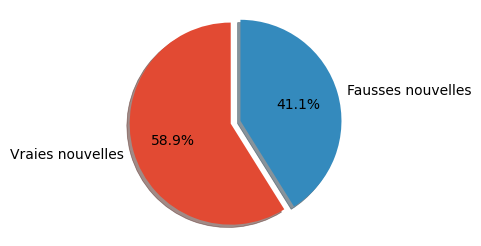

In [ ]:
plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 100

labels = ['Vraies nouvelles', 'Fausses nouvelles']
sizes = [total_true, total_false]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

### Code affichant le nombre de vraies et fausses nouvelles par régions
Il est important de noter que nous affichons seulement les régions ayant le plus d'articles, puisque notre base de données possède une centaine de régions.

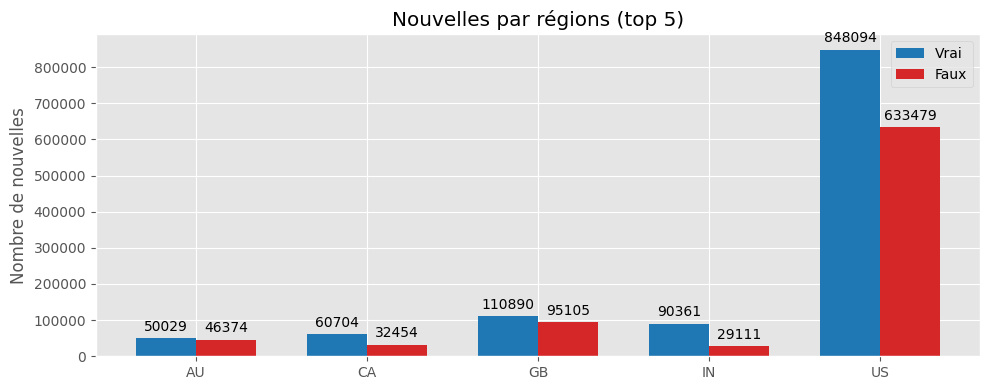

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100

top_true_region = sorted(region_dict_true, key=region_dict_true.get, reverse=True)[:5]
top_false_region = sorted(region_dict_false, key=region_dict_false.get, reverse=True)[:5]
top_region_combined = sorted(set(top_true_region+top_false_region))

t_news_count = []
f_news_count = []

for x in range(len(top_region_combined)):
    if top_region_combined[x] in region_dict_true:
        t_news_count.append(region_dict_true[top_region_combined[x]])
    if top_region_combined[x] not in region_dict_true:
        t_news_count.append(0)
    if top_region_combined[x] in region_dict_false:
        f_news_count.append(region_dict_false[top_region_combined[x]])
    if top_region_combined[x] not in region_dict_false:
        f_news_count.append(0)
        

x = np.arange(len(top_region_combined))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, t_news_count, width, label='Vrai', color='tab:blue')
rects2 = ax.bar(x + width/2, f_news_count, width, label='Faux', color='tab:red')

ax.set_ylabel('Nombre de nouvelles')
ax.set_title('Nouvelles par régions (top 5)')
ax.set_xticks(x, top_region_combined)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

### Code affichant le nombre de vraie et fausse nouvelles par date

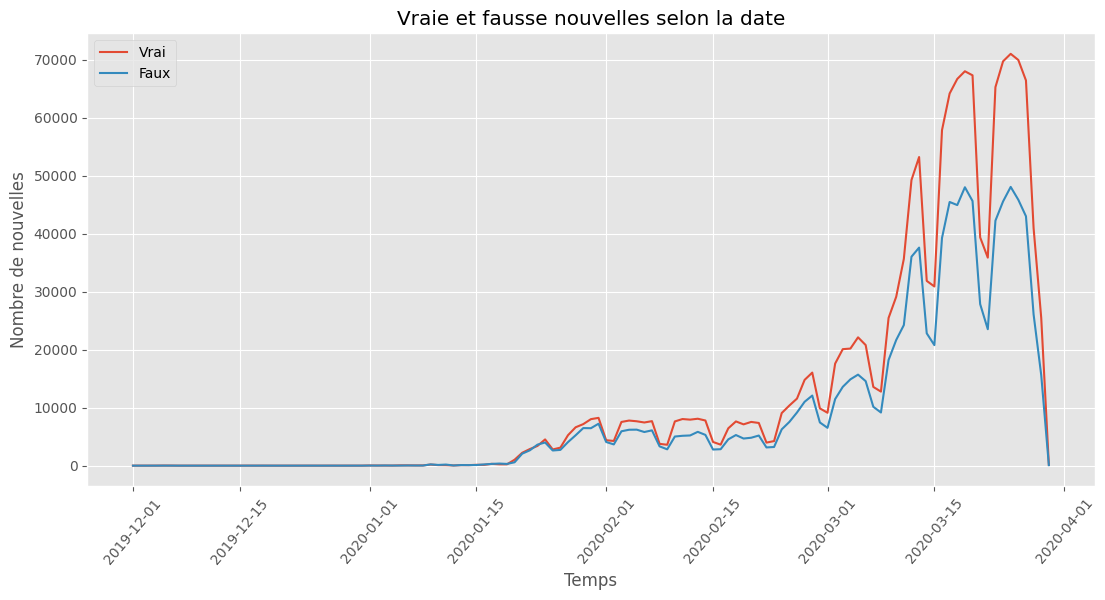

In [ ]:
import collections
import datetime as dt
import matplotlib.dates as mdates
import numpy as np

plt.rcParams['figure.figsize'] = [13, 6]
plt.rcParams['figure.dpi'] = 100

# Ajout des dates manquantes par dict
for key in date_dict_true:
    if key not in date_dict_false.keys():
        date_dict_false.update({key: 0})
        
for key in date_dict_false:
    if key not in date_dict_true.keys():
        date_dict_true.update({key: 0})

# Mettre les dates en ordre
ddt_sorted = collections.OrderedDict(sorted(date_dict_true.items()))
date_key_true = list(ddt_sorted.keys())
date_value_true = list(ddt_sorted.values())

ddf_sorted = collections.OrderedDict(sorted(date_dict_false.items()))
date_key_false = list(ddf_sorted.keys())
date_value_false = list(ddf_sorted.values())

# Affichage des résultats
dates = mdates.date2num(date_key_true)
width = np.diff(dates).min()

plt.plot(mdates.num2date(dates), date_value_true, label = 'Vrai')
plt.plot(mdates.num2date(dates), date_value_false, label = 'Faux')

plt.xlabel('Temps')
plt.ylabel('Nombre de nouvelles')
plt.title('Vraie et fausse nouvelles selon la date')

plt.xticks(rotation=50)
ax.xaxis_date()
fig.autofmt_xdate()

plt.legend()
plt.show()

### Code affichant le nombre en moyenne de like par type de nouvelles

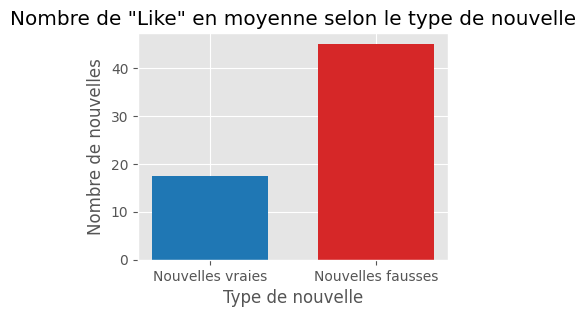

In [ ]:
plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 100

left = [1, 2]
height = [total_like_true_source/total_true, total_like_fake_source/total_false]

tick_label = ['Nouvelles vraies', 'Nouvelles fausses']

plt.bar(left, height, tick_label = tick_label, width = 0.7, color = ['tab:blue', 'tab:red'])

plt.xlabel('Type de nouvelle')
plt.ylabel('Nombre de nouvelles')
plt.title('Nombre de "Like" en moyenne selon le type de nouvelle')

plt.show()

### Code affichant le nombre en moyenne de partage par type de nouvelles

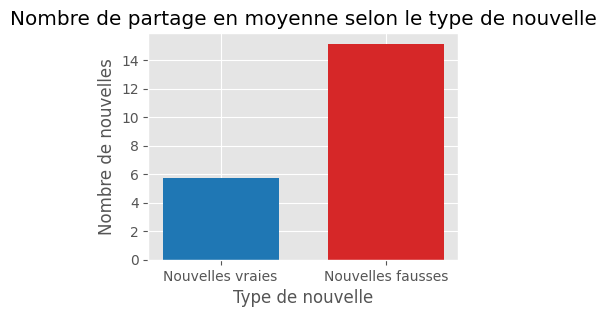

In [ ]:
plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 100

left = [1, 2]
height = [total_share_true_source/total_true, total_share_fake_source/total_false]

tick_label = ['Nouvelles vraies', 'Nouvelles fausses']

plt.bar(left, height, tick_label = tick_label, width = 0.7, color = ['tab:blue', 'tab:red'])

plt.xlabel('Type de nouvelle')
plt.ylabel('Nombre de nouvelles')
plt.title('Nombre de partage en moyenne selon le type de nouvelle')

plt.show()

### Code affichant le spam score selon le type de source

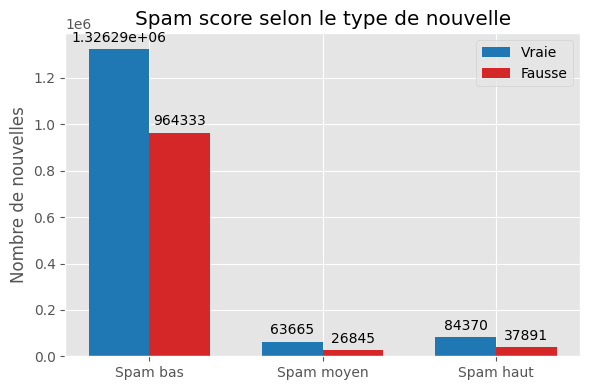

In [ ]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

labels = ['Spam bas', 'Spam moyen', 'Spam haut']

spam_score_true = [total_vrai_bas_risque, total_vrai_medium_risque, total_vrai_haut_risque]
spam_score_false = [total_faux_bas_risque, total_faux_medium_risque, total_faux_haut_risque]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, spam_score_true, width, label='Vraie', color='tab:blue')
rects2 = ax.bar(x + width/2, spam_score_false, width, label='Fausse', color='tab:red')

ax.set_ylabel('Nombre de nouvelles')
ax.set_title('Spam score selon le type de nouvelle')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# Conclusion
Afin d'obtenir les conclusions de nos recherches, ainsi que toutes nos sources, nous vous invitons à lire notre rapport complet: https://github.com/BernierS/Analyse_de_fausses_nouvelles